In [1]:
from project.models.char_baseline import CharSeqBaseline
from project.models.code2vec_solo import Code2VecSolo
from project.models.code2vec_encoder import Code2VecEncoder
from project.models.base_model import _run_model


/home/ehambro/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# load_dir = {"logdir":"logs/BIG_X_new_attention_second_experiment__var_otherargs_2008_102707/best_bleu", "mode":"RETURN"}
# load_dir = {"logdir":"logs/new_attention_second_experiment__var_otherargs_1808_200101/best_bleu", "mode":"RETURN"}
# load_dir = {"logdir":"logs/SMALL_lstm_otherargs_cross_ent", "mode":"RETURN"}
load_dir = {"logdir":"logs/reboot_second_var_only", "mode":"RETURN"}
LOADED = _run_model(CharSeqBaseline, **load_dir)


LOADING FROM: logs/reboot_second_var_only, overwriting kwargs


Loading GloVe weights and word to index lookup table


400000it [00:07, 52611.14it/s]


Creating char to index look up table
Tokenizing the word descriptions and characters
Tokenizing the src code
Extracting tensors train and test
INFO:tensorflow:Restoring parameters from logs/reboot_second_var_only/BasicModel.ckpt-17097


0822_21:05 WARNING - Loaded from logs/reboot_second_var_only: Global Step 17097


In [3]:
sess, nn, data_tuple, step = LOADED

In [4]:
# RESULTS = nn.evaluate_bleu(sess, data_tuple.test, max_translations=10000)

In [5]:
import random
import numpy as np
from tqdm import tqdm 
from project.external.nmt import bleu


def prep_samples(translations, sample_size, no_samples):
    for n in range(no_samples):
        yield  random.choices(translations, k=sample_size)
        
def get_translations(nn, data):
    return nn.evaluate_bleu(sess, data, max_translations=10000)

def get_bleu_bootstrap(translations, sample_size = 1000, no_samples = 1000):
    bleu_bootstrap = []
    total = []
    for sample in prep_samples(translations, sample_size, no_samples):
        all_references = [[t.description] for t in sample]
        all_translations = [t.translation for t in sample ]
        b = bleu.compute_bleu(all_references, all_translations, max_order=4, smooth=False)
        bleu_bootstrap.append(b[0]*100)
    return bleu_bootstrap
    

In [6]:
import pickle
from collections import namedtuple
from  matplotlib import pyplot as plt 

Examples = namedtuple("Examples", ["translations", "data_tuple"])

def find_examples(translations, data_tuple):
    return_index = []
    return_data = [[] for  _ in data_tuple.test]
    for t in translations:
        for i,d in enumerate(data_tuple.test[-1]):
            arg_name = "".join(nn.translate(data_tuple.test[0][i], lookup=nn.idx2char, do_join=False))
            if d == t.description and arg_name == t.name:
                return_index.append(i)
    
    for j in return_index:
        for k, d in enumerate(return_data):
            d.append(data_tuple.test[k][j])
    
    return [np.stack(x) for x in return_data[:-1]] + [return_data[-1]]

def load_examples(name):
    with open("examples/{}.eg.pkl".format(name), 'rb') as f:
         examples = pickle.load(f)
    return examples

def save_examples(name, good_data_tuple):
    with open("examples/{}.eg.pkl".format(name), 'wb') as f:
        pickle.dump(good_data_tuple, f)


In [7]:
# T200  = get_translations(nn, data_tuple.test[:200])
# find_in_train("binary image", data_tuple, nn)
# selected_data = pickout_data(T200, [47,48], data_tuple)
# for i, t in enumerate(T200[-1]):
#     print(i,t)
#     print(latex_translation(t))

-----
\textbf{I}: \mintinline[]{python}{i n p u t $<$SEP-1$>$ s t r u c t u r e $<$SEP-2$>$ m a s k $<$SEP-2$>$ o u t p}...\\
...\mintinline[]{python}{u t $<$SEP-2$>$ b o r d e r \_ v a l u e $<$SEP-2$>$ o r i g i n $<$SEP-2$>$ $<$END$>$}\\
\textbf{D}: binary image to be propagated inside ` mask ` .\\
\textbf{P}: if not ` none ` , compute the input to the $<$UNK$>$ of the $<$UNK$>$ convolution . $<$END$>$\\
\\\hline\\

\textbf{I}: \mintinline[]{python}{i n p u t $<$SEP-1$>$ n a m e $<$SEP-2$>$ $<$END$>$}\\
\textbf{D}: a ` tensor ` of type ` complex64 ` . a complex64 tensor .\\
\textbf{P}: name of the input node to be used as the model . $<$END$>$\\
\\\hline\\

\textbf{I}: \mintinline[]{python}{e n c o d i n g \_ t y p e $<$SEP-1$>$ s e l f $<$SEP-2$>$ d o c u m e}...\\
...\mintinline[]{python}{n t $<$SEP-2$>$ r e t r y $<$SEP-2$>$ t i m e o u t $<$SEP-2$>$ $<$END$>$}\\
\textbf{D}: the encoding type used by the api to calculate offsets .\\
\textbf{P}: a dictionary that maps the threads 

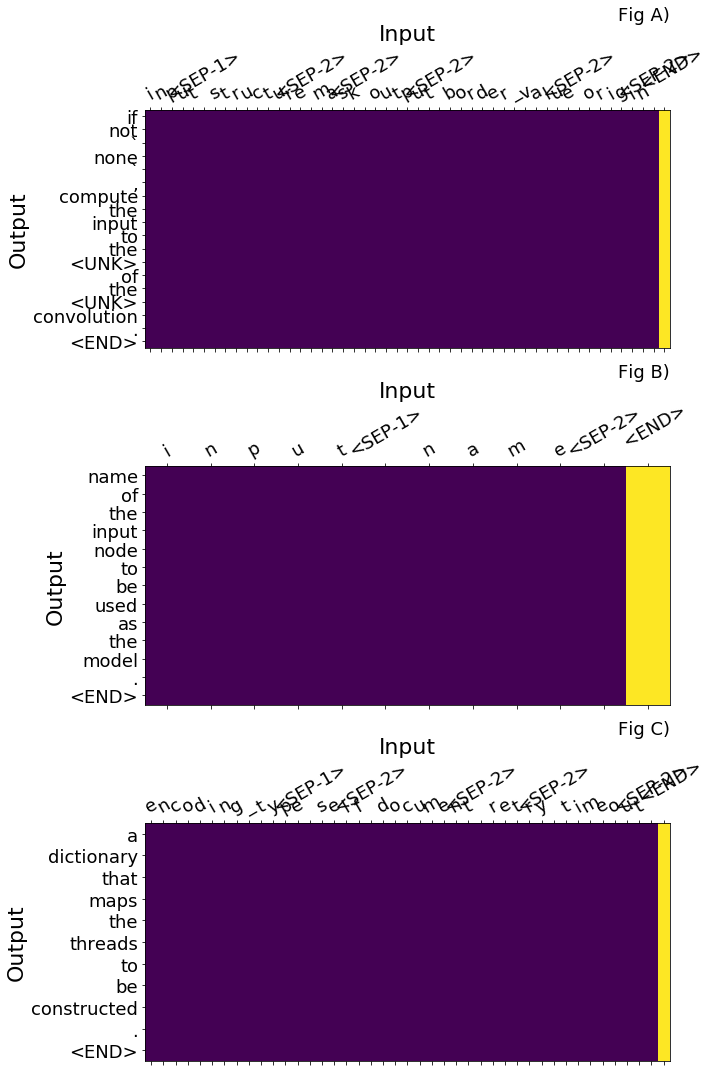

ValueError: need at least one array to stack

In [8]:
def plot_attentions(dataset, max_p=None, figsize=(10,15)):
    if max_p is None:
        max_p =  len(dataset[-1])
     
    fig, ax = plt.subplots(max_p,figsize=figsize )
    F="ABCDEFG"
    
    if max_p == 1:
        ax = [ax]
    for j, desc in enumerate(dataset[-1]):

        just_one = [ i[j:j+1] for i in dataset ]
        
        trim = len(np.trim_zeros(just_one[0][0])) 
        alignments, translate = nn._feed_fwd(sess, just_one, [nn.inf_state.alignment_history.stack(), nn.inference_id] )
        char_input1 = nn.translate(just_one[0][0], lookup=nn.idx2char, do_join=False)
        
        c_input = " ".join(char_input1)
        
        
        char_input = [c.replace("<SEP-", "   <S-") for c in char_input1]
        char_input = [c.replace("<END", "   <END") for c in char_input1]
        
        word_output = nn.translate(translate[0], do_join=False)
        
        print(latex_translation([char_input1, desc, word_output ]))
        print("\\\\\\hline\\\\")
        print()
        if j == max_p:
            break
        moved = np.squeeze(alignments)
        moved = np.stack([i[:trim] for i in moved])
        moved[:,trim:] = 0.5
        
        
        ax[j].set_title("Fig {})\n\n\n\n".format(F[j]), loc="right", fontsize=18)
        ax[j].matshow(moved, aspect="auto")
#        
        ax[j].set_xticks(np.arange(len(char_input)))
        ax[j].set_xticklabels( char_input, rotation=30,  fontsize=18)
        ax[j].set_yticks(np.arange(len(word_output)))
        ax[j].set_yticklabels(word_output, fontsize=18)
        ax[j].set_ylabel("Output", fontsize=22)
        ax[j].set_xlabel("Input", fontsize=22)
        ax[j].xaxis.set_label_position('top') 
    
    plt.tight_layout()
    plt.show()

def latex_translation(t):
    to_tex = lambda  s:s.replace("<", "$<$").replace(">", "$>$").replace("_","\\_")
    split = 25
    n1 = t[0][:split]
    n1 = "\\textbf{I}: \mintinline[]{python}{" + to_tex(" ".join(n1)) + "}"
    if len(t[0]) > split:
        n1 += "...\\\\\n...\mintinline[]{python}{"+to_tex(" ".join(t[0][split:])) + "}"
    n1 += "\\\\"
    desc = "\\textbf{D}: " + to_tex(" ".join(t[1])) + "\\\\"
    pred = "\\textbf{P}: " + to_tex(" ".join(t[2])) + "\\\\"
    return "\n".join([n1, desc, pred])

    
    
def find_in_train(desc, data_tuple, nn):
    for i,t in enumerate(data_tuple.train[-1]):
#         print(t)
        if desc in " ".join(t):
            chars = nn.translate(data_tuple.train[0][i], lookup=nn.idx2char, do_join=False)
            print(latex_translation([chars, t, [""]]))
            print("\n")
            
def pickout_data(translations, indices, data_tuple):
    trans = [translations[-1][i] for i in indices] 
    return find_examples(trans, data_tuple)

def find_char_starts_with_TRAIN(array):
    input_egs_idx = []
    for i, r in enumerate(data_tuple.train[0]):
        if np.array_equal(r[:len(array)], array):
            input_egs_idx.append(i)
    input_egs = []
    for d in data_tuple.train[:-1]:
    
        input_egs.append(np.stack([d[i] for i in input_egs_idx]))
    input_egs.append([data_tuple.train[-1][i] for i in input_egs_idx])
    for i,r in enumerate(input_egs[0]):
        print(latex_translation([nn.translate(r, lookup=nn.idx2char, do_join=False), input_egs[-1][i], ""]))
    

print("-----")
REPORT_PLOT_DATA = load_examples('SECOND_EXPERIMENT_otherargs___REPORT_binary_input_enc')
plot_attentions(REPORT_PLOT_DATA, 3)



def find_starting__input_SEP_structure():
    return find_char_starts_with_TRAIN(np.array([9, 14, 16, 21, 20, 65, 19, 20, 18, 21,  3, 20 ,21, 18,  5]))

find_starting__input_SEP_structure()

IndexError: list index out of range

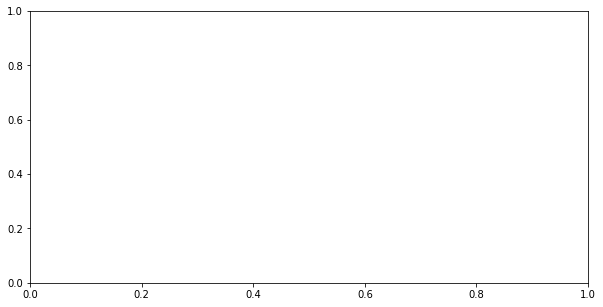

In [53]:
plot_attentions([i[2:3,:] for i in REPORT_PLOT_DATA[:-1]] + [REPORT_PLOT_DATA[-1][2]], 1, figsize=(10,5))


# Rote Learner

In [9]:
from nltk.translate.bleu_score import sentence_bleu
def latex_translation(t):
    to_tex = lambda  s:s.replace("<", "$<$").replace(">", "$>$").replace("_","\\_")
    split = 25
    n1 = t[0][:split]
    n1 = "\\textbf{Argument}: \mintinline[]{python}{" + to_tex(" ".join(n1)) + "}"
    if len(t[0]) > split:
        n1 += "...\\\\\n...\mintinline[]{python}{"+to_tex(" ".join(t[0][split:])) + "}"
    n1 += "\\\\"
    desc = "\\textbf{D}: " + to_tex(" ".join(t[1])) + "\\\\"
    pred = "\\textbf{P}: " + to_tex(" ".join(t[3])) + "\\\\"
    return "\n".join([n1, desc, pred])

    
def get_bleu_from_translation(HB, hb_trans, chop_tokens=True):
    
    if chop_tokens:
        bleu_scores = [sent_bleu([t.description], t.translation[1:-1]) for t in hb_trans]
    else:
        bleu_scores = [sent_bleu([t.description], t.translation) for t in hb_trans]
        
    return bleu_scores

def get_sentence_samples(bleu_scores, translations, max_no):
    bleu_points = [0,0,0,1,3,5,7,9,10,10,]
    
    print("\\begin{table}\n\\begin{center}\n\\begin{tabular}{l}\n")
    print("\nA Random Sample of Bleu Scores \\\\ \n\n ")
    
    for i, b, h in zip(range(max_no),bleu_scores, translations):
        print("\\textbf{B}:"+" {:.3f}".format(b))
        print("\\textbf{C}:"+ " {:.1f}%  \\\\".format(100/h.choices))
        print(latex_translation(h))
        print("\\\\")
    
    print("\\hline\\\\\\\\")
    greater_than_point5 = [(b,t) for b,t in zip(bleu_scores, translations) if b>0.001]
    
    print("\n\nA Random Sample of Bleu Scores $>0.5$ \\\\\\\\ \n\n")
    for i, (b, h )in zip(range(3),greater_than_point5):
        print("\\textbf{B}:"+" {:.3f}".format(b))
        print("\\textbf{C}:"+ " {:.1f}%  \\\\".format(100/h.choices))
        print(latex_translation(h))
        print()
    
    print("\end{tabular}\n\end{center}\n\end{table}\n")
    

def sent_bleu(r, t):
    return sentence_bleu(r, t, weights=(0.25,0.25,0.25,0.25))

def score_bleu_individually(all_trans, all_attn, references, nn):
    flat_trans = [row for m in all_trans for row in m]
    flat_attn = [row for m in all_attn for row in m]

    flat_full_translations = [nn.translate(i, do_join=False, prepend_tok=nn.word2idx["<START>"])[1:-1] 
                              for i in flat_trans]
    bleu_scores = [sent_bleu([r], t) for r,t in zip(references, flat_full_translations)]
    return bleu_scores


def plot_hist_2(data_and_labels):
    fig, ax = plt.subplots(1, figsize=(10,5))
    for x,l,a in data_and_labels:
        ax.hist(x, bins=50, alpha=a, label=l)
    ax.set_title("Histogram of Sentence Level Bleu Scores on Validation Set", fontsize=20)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(14) 
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(14) 
    ax.set_ylabel("Counts", fontsize=18)
    ax.set_xlabel("Sentence Bleu Score", fontsize=16)
    ax.legend(fontsize = 'xx-large')
    plt.yscale('log')
    plt.show()

In [10]:
from project.models.hashtable_baseline import HashtableBaseline, _run_model

# HB.train(data_tuple.train)

def load_baseline(load_dir,mode):
    with open(load_dir['logdir']+'/args.pkl', 'rb') as f:
        args = pickle.load(f)
        args['code_mode'] = [mode]
        args['n_times'] = 1
        args['logfile'] = load_dir['logdir']+'/hashtable_main'
        
        if "path_seq" not in args:
            args["path_seq"] = 5000 #Defaults
            args["path_vocab"] = 10000
            args["path_embed"] = 200
            args["vec_sized"] = 300
    return _run_model(**args)

In [11]:
import pickle
# load_dirRL = {"logdir":"logs/new_attention_fourfive_c2v_solo_canond0.1/best_bleu", "mode":"RETURN"}

# load_dirRL = {"logdir":"logs/new_attention_second_experiment__var_otherargs_1808_200101/best_bleu", "mode":"RETURN"}
# load_dirRL = {"logdir":"logs/second_experiment_70dim/second_experiment__var_only_0808_102118/", "mode":"RETURN"}



HB_combined, d_combined = load_baseline(load_dir,"none")
hb_trans_combined = HB_combined.test(d_combined[1])

Loading GloVe weights and word to index lookup table


400000it [00:07, 55528.44it/s]
  0%|          | 0/15687 [00:00<?, ?it/s]


------------------------------------------------------
------------------------------------------------------
MODEL: HashtableBaseline
Name: Hashtable Model

Args: code_mode: none, code_only: False
------------------------------------------------------
ARGS:
batch_size : 128
bidirectional : True
char_seq : 120
code_mode : ['none']
code_tokenizer : code2vec
desc_embed : 200
desc_seq : 120
dropout : 0.1
epochs : 150
git : b"'dc5139d'"
learning_rate : 0.001
logdir : logs
logfile : logs/reboot_second_var_only/hashtable_main
lstm_size : 300
n_times : 1
name : new_attention_second_experiment__var_only
no_dups : 1
path_embed : 200
path_seq : 5000
path_vocab : 10000
save_every : 1
test_freq : 200
test_translate : 5
tokenizer : var_only
use_attention : True
use_full_dataset : True
use_split_dataset : False
vec_sized : 300
vocab_size : 40000
------------------------------------------------------
------------------------------------------------------



8.971247814425704
----- 1 -----
VALID  8.97125 +/-  0.00000   TEST  10.99470 +/-  0.00000 
      & $ 8.97125 \pm  0.00000 $ & $ 10.99470 \pm 0.00000 $ &


Mode: none,  Score 8.97125 +/- 0.00000


In [60]:
i = 0
lens = []
bs = []

for b,t in zip(bs_s2s, RESULTS[-1]):
    if "name<END>" == t.name:
        bs.append(b)
        T = t.translation

print(np.mean(b), np.std(b), T)
print(i)
# print(np.mean(lens))

i = 0
lens = []
bs = []
for b,t in zip(bs_rl_comb,hb_trans_combined):
    if "name" == t.name:
#         print(t)
        i += 1
        bs.append(b)
        
    if b > 0.00000000000000001:
        lens.append(len(t.translation))
# print(np.mean(b), i)

# print(np.mean(lens))

def test___name__():
    all_bs =[]
    for i in range(50):
        random.seed(i)
        hb_trans_combined = HB_combined.test(d_combined[1])
        bs = get_bleu_from_translation(HB_combined, hb_trans_combined)
        name_bs =[]
        for b,t in zip(bs,hb_trans_combined):
            if "name" == t.name:
                name_bs.append(b)
        all_bs.append(np.mean(name_bs))
    return np.mean(all_bs), np.std(all_bs), all_bs
        
mean, std, all_bs = test___name__()
print(mean, std)

0.40292759186936566 0.0 ['name', 'of', 'the', 'variable', 'to', 'return', '.']
0


/home/ehambro/anaconda3/lib/python3.6/site-packages/nltk/translate/bleu_score.py:503: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ehambro/anaconda3/lib/python3.6/site-packages/nltk/translate/bleu_score.py:503: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ehambro/anaconda3/lib/python3.6/site-packages/nltk/translate/bleu_score.py:503: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use S

0.006484082299914484 0.006171655665750054


In [52]:
[d['arg_desc'] for d in d_combined[0] if d['arg_name']=='name']



[' The name of a required header.',
 ' String, name for the variable to create.',
 ' the name of the keyword argument (should always be "message_extractors")',
 ' An optional name for the variable_scope that contains the metric variables.',
 ' Name of the variable.',
 ' Add the Series name if not None',
 ' ``projects/{project_id}/transferConfigs/{config_id}``',
 ' Optional name of the op.',
 ' Optional name for the accumulator.',
 ' the name of the command to use unless a group overrides it.',
 ' Name of the node attribute to set if values is a scalar.',
 ' the name of the data type to look for in *conn_or_curs*',
 ' Name of the dataset (`name`.csv on https://github.com/mwaskom/seaborn-data).  You can obtain list of available datasets using :func:`get_dataset_names`',
 ' ``projects/{project_id}/transferConfigs/{config_id}/runs/{run_id}``',
 ' Optional name for the returned tensor.',
 ' A name for the generated node. Will also serve as the series name in TensorBoard.',
 ' name of the pr

In [14]:
import numpy as np
from matplotlib import pyplot as plt
bs_rl_comb  = get_bleu_from_translation(HB_combined, hb_trans_combined)
rote_comb_lerner_entropies = [-np.log(1.0/t.choices) for t in hb_trans_combined]
get_sentence_samples(bs_rl_comb,hb_trans_combined, 4)

for b,t in zip(bs_rl_comb,hb_trans_combined):
    if b ==1:
        print(b,t)
RESULTS = nn.evaluate_bleu(sess, data_tuple.valid, max_translations=10000)
bs_s2s = get_bleu_from_translation(None, RESULTS[-1])

/home/ehambro/anaconda3/lib/python3.6/site-packages/nltk/translate/bleu_score.py:503: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ehambro/anaconda3/lib/python3.6/site-packages/nltk/translate/bleu_score.py:503: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ehambro/anaconda3/lib/python3.6/site-packages/nltk/translate/bleu_score.py:503: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use S

\begin{table}
\begin{center}
\begin{tabular}{l}


A Random Sample of Bleu Scores \\ 

 
\textbf{B}: 0.000
\textbf{C}: 25.0%  \\
\textbf{Argument}: \mintinline[]{python}{k e y \_ i d}\\
\textbf{D}: optional key id used to identify this private key . this can be useful to associate the private key with its associated public key or certificate .\\
\textbf{P}: $<$START$>$ $<$UNK$>$ access key id $<$END$>$\\
\\
\textbf{B}: 0.000
\textbf{C}: 0.3%  \\
\textbf{Argument}: \mintinline[]{python}{o u t}\\
\textbf{D}: if none , a new array is allocated .\\
\textbf{P}: $<$START$>$ a ` tensor ` of type ` $<$UNK$>$ ` . dimension 0 of `` data '' passed to $<$UNK$>$ op . $<$END$>$\\
\\
\textbf{B}: 0.000
\textbf{C}: 100.0%  \\
\textbf{Argument}: \mintinline[]{python}{t e n s o r \_ n a m e \_ r e g e x}\\
\textbf{D}: the regular-expression pattern of the name ( s ) of the x-tensor ( s ) to watch . x-tensor refers to the tensors on the denominator of the differentiation .\\
\textbf{P}: $<$START$>$ name of

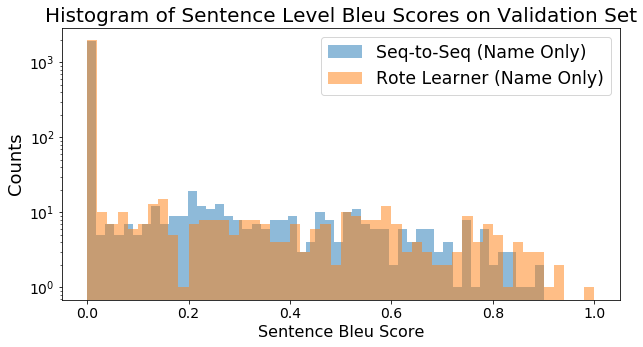

0.050302438139629854
0.053781833228355565


In [16]:
plot_hist_2([
    (bs_s2s,'Seq-to-Seq (Name Only)', 0.5), 
    (bs_rl_comb,'Rote Learner (Name Only)', 0.5), 
])
print(np.mean(bs_rl_comb))
print(np.mean(bs_s2s))

In [ ]:
get_sentence_samples(bs_rl,hb_trans, 4)

In [ ]:
# bleu_bootstrap = get_bleu_bootstrap(T[-1], sample_size=1000, no_samples=1000)

In [ ]:
# print("{:.5f}, {:.5f}".format(np.mean(bleu_bootstrap), np.std(bleu_bootstrap)))

# print("{:.5f}, {:.5f}".format(np.mean(sorted(bleu_bootstrap)[25:-25]), np.std(sorted(bleu_bootstrap)[25:-25])))

In [ ]:
# [print(i, t) for i, t in enumerate(T[-1])]

### Other Stuff

In [ ]:
egs = load_examples('input_otherargs')
egs2 = load_examples('new_attn_otherargs')

T2  = get_translations(nn, egs2)

In [ ]:

#     print("\\\\\n\\hline\n\\\\")
    print("--------------")

In [ ]:
char_embeddings = nn.get_scope_variable(sess, 'embed_vars', 'char_embed')

In [ ]:
len(data_tuple.test[-1])


In [ ]:
#"\n".join("\t".join([str(j) for j in i]) for i in char_embeddings[0]) 
print("\n".join(["Char"] + [nn.idx2char[i] for i in sorted(nn.idx2char.keys())]))
